In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot
from epi.SC_Circuit_4 import SC_acc, SC_sim, unwrap, SC_acc_diff
import seaborn as sns
import os


### 1. Define the V1Circuit model

In [7]:
lb = -5.
ub = 5. 

sW = Parameter("sW", 1, lb=lb, ub=2.)
vW = Parameter("vW", 1, lb=lb, ub=0.)
dW = Parameter("dW", 1, lb=lb, ub=0.)
hW = Parameter("hW", 1, lb=lb, ub=0.)
"""sW = Parameter("sW", 1, lb=-2., ub=1.)
vW = Parameter("vW", 1, lb=-5., ub=-2.)
dW = Parameter("dW", 1, lb=-4., ub=1.)
hW = Parameter("hW", 1, lb=-2., ub=-.5)"""

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit", parameters)

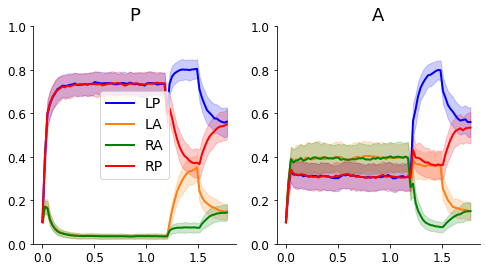

In [8]:
z = np.array([[-1.7, -0.2567, 0.22, -2.43]], dtype=np.float32)

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

u_t, v_t = SC_sim(*unwrap(-np.ones((1,4), dtype=np.float32)))

neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = ['b', 'tab:orange', 'g', 'r']
C_titles = ['P', 'A']
for m in range(1):
    fig, axs = plt.subplots(1,2,figsize=(8, 4))
    for c in range(2):
        for i in range(4):
            mean_v = np.mean(v_t[:,m,c,i,:], axis=1)
            std_v = np.std(v_t[:,m,c,i,:], axis=1)
            axs[c].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c].set_title(C_titles[c])
            axs[c].set_ylim([0,1])
    axs[0].legend()
    plt.show()


### 2. Define eps function using Euler

In [9]:
model.set_eps(SC_acc)

def accept_inds(T_x, means, stds):
    acc = np.array([np.logical_and(means[i] - 2*stds[i] < T_x[:,i], 
                    T_x[:,i] < means[i] + 2*stds[i]) for i in range(len(means))])
    return np.logical_and.reduce(acc, axis=0)
                          

In [11]:
import time
num_keep = 200
M = 1000
zs = []
T_xs = []

p = .75
means = [p, 1-p]
stds = [0.05, 0.05]

_round = 0
num_found = 0
z = None
T_x = None
while (num_found < num_keep):
    _round += 1
    time1 = time.time()
    _z = np.zeros((M, model.D), dtype=np.float32)
    for j in range(model.D):
        _z[:,j] = np.random.uniform(model.parameters[j].lb, model.parameters[j].ub, (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, means, stds) 
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    time2 = time.time()
    print('r%d %d/%d %.1f s\r' % (_round, num_found, num_keep, time2-time1), end='')

    num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]

num_plot = 500
fontsize = 20

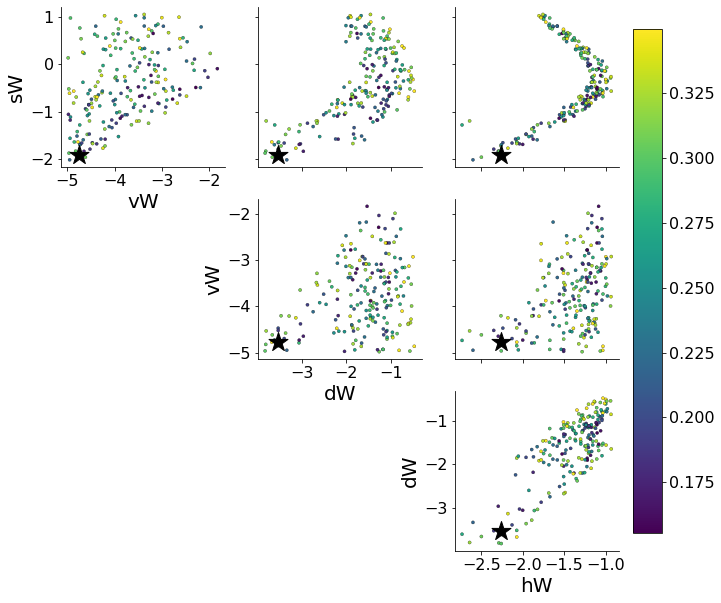

In [13]:
z_labels = [p.name for p in model.parameters]
#z_star = np.mean(z, axis=0)[None,:]
z_star = z[0,:][None,:]

inds = z[:,0] < 5.
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])
fig = pairplot(z[inds], np.arange(4), z_labels,
               fontsize=fontsize, figsize=(10,10), starred=z_star,
               c = T_x[inds,1])

In [22]:
from epi.SC_Circuit_4 import get_schur_eigs

sW = z[:,0]
vW = z[:,1]
dW = z[:,2]
hW = z[:,3]

Wrow1 = np.stack([sW, vW, dW, hW], axis=1)
Wrow2 = np.stack([vW, sW, hW, dW], axis=1)
Wrow3 = np.stack([dW, hW, sW, vW], axis=1)
Wrow4 = np.stack([hW, dW, vW, sW], axis=1)

W = np.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=1)

eigs = np.array([get_schur_eigs(W[i]) for i in range(sW.shape[0])])
eig_names = ['all', 'side', 'task', 'diag']

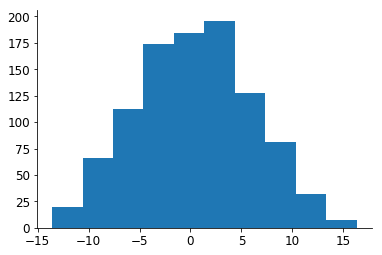

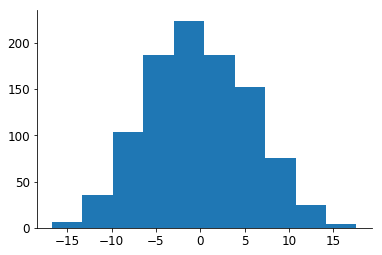

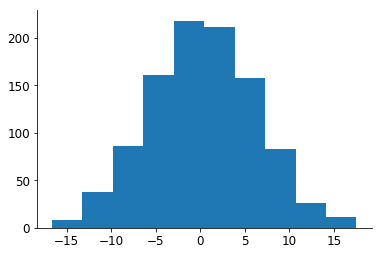

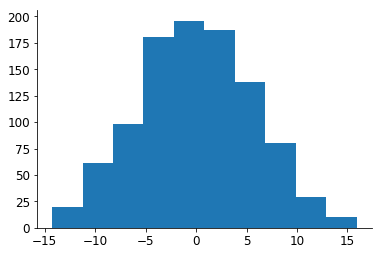

In [23]:
for i in range(4):
    plt.figure()
    plt.hist(eigs[:,i])
    plt.show()

delay 0.0
delay 0.05
delay 0.1
delay 0.15000000000000002
delay 0.2
delay 0.25
delay 0.30000000000000004
delay 0.35000000000000003
delay 0.4
delay 0.45
delay 0.5
delay 0.55
delay 0.6000000000000001
delay 0.65
delay 0.7000000000000001
delay 0.75
delay 0.8
delay 0.8500000000000001
delay 0.9
delay 0.9500000000000001
delay 1.0
choice 0.0
choice 0.05
choice 0.1
choice 0.15000000000000002
choice 0.2
choice 0.25
choice 0.30000000000000004
choice 0.35000000000000003
choice 0.4
choice 0.45
choice 0.5
choice 0.55
choice 0.6000000000000001
choice 0.65
choice 0.7000000000000001
choice 0.75
choice 0.8
choice 0.8500000000000001
choice 0.9
choice 0.9500000000000001
choice 1.0
total 0.0
total 0.05
total 0.1
total 0.15000000000000002
total 0.2
total 0.25
total 0.30000000000000004
total 0.35000000000000003
total 0.4
total 0.45
total 0.5
total 0.55
total 0.6000000000000001
total 0.65
total 0.7000000000000001
total 0.75
total 0.8
total 0.8500000000000001
total 0.9
total 0.9500000000000001
total 1.0


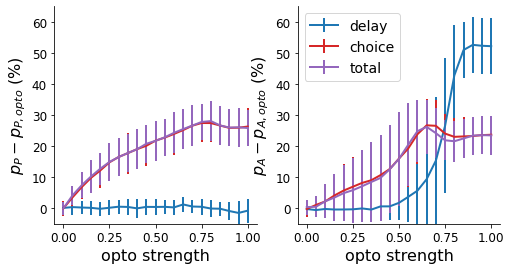

In [17]:
periods = ['delay', 'choice', 'total']
strengths = np.linspace(0., 1., 21)
diffs = []
approx_num = 100

for period in periods:
    _diffs = []
    for strength in strengths:
        print(period, strength)
        sc_acc_diff = SC_acc_diff(strength, period)
        _diff = sc_acc_diff(*unwrap(z[:approx_num])).numpy()
        _diff[:,1] = -_diff[:,1]
        _diffs.append(_diff)
    diffs.append(np.array(_diffs))
    
pal = sns.color_palette()
opto_colors = [pal[i] for i in [0, 3, 4]]
ylabels = [r'$p_P-p_{P,opto}$ (%)', r'$p_A-p_{A,opto}$ (%)']

fig, axs = plt.subplots(1,2,figsize=(8,4))
for i, period in enumerate(periods):
    diff_mean = np.mean(100.*diffs[i], axis=1)
    diff_std = np.std(100.*diffs[i], axis=1)
    for j in range(2):
        axs[j].errorbar(1.-strengths, diff_mean[:,j], diff_std[:,j],
                        c=opto_colors[i], label=period)

for j in range(2):
    axs[j].set_xlabel('opto strength')
    axs[j].set_ylabel(ylabels[j])
    axs[j].set_ylim([-5, 65])
axs[1].legend()
#plt.savefig(os.path.join(figdir, "FigSX4.pdf"))